In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten, Input
from tensorflow.keras import Model
import tensorflow as tf

df = yf.download("MSFT", start="2020-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))
df = df[['Close']].copy()

C:\Users\anany\AppData\Local\Temp\ipykernel_8060\1516487072.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("MSFT", start="2020-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 60)

In [31]:
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [32]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__() #calls Layer's init method
        #ensure parent content properly initialised
        self.max_len = max_len #look back period / sequence length
        self.embed_dim = embed_dim #dimension to project each feature to - richer representation
        #increases number of features to represent a particular word/token
        self.token_emb = Dense(embed_dim) #projects each feature to embed_dim number of dimensions
        #positional encoding will be a learned embedding for each position
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim) 
        #maps each integer using a lookup to a embed_dim size vector

    def call(self, x): #defines forward pass of the layer at each node
        #here x contains a single closing price value
        #create a positional index for each element
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        # Apply the token embedding and positional embedding
        x = self.token_emb(x) #produces multi-dimensional representation for each x out of 60
        #the predicted prices are obtained here
        positions = self.pos_emb(positions) #produces 60,32 sized vector 
        #containing a vector learned for each position by the embedding layer
        #positional encoding output remains same for any input x
        return x + positions #combine the info

In [33]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.05):
        super(TransformerBlock, self).__init__() #parent initialisation
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        #each head focuses on a different aspect of the input sequence
        #each head processes own part of data in parallel - results concatenated
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        ) #produces representation in embed_dim dimension - non-linearity
        self.layernorm1 = LayerNormalization(epsilon=1e-6) #normalises features across inputs
        self.layernorm2 = LayerNormalization(epsilon=1e-6) #epsilon added to denominator to prevent division by 0
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # Attention and normalization
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network and normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    

In [34]:
from tensorflow.keras.optimizers import Adam
inputs = Input(shape=(60, 1))
x = TokenAndPositionEmbedding(60, 64)(inputs)
x = TransformerBlock(64, 2, 32)(x)
x = Flatten()(x)
x = Dense(1, activation='linear')(x) #to output single value prediction

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 token_and_position_embeddi  (None, 60, 64)            3968      
 ng_7 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_7 (Trans  (None, 60, 64)            37664     
 formerBlock)                                                    
                                                                 
 flatten_6 (Flatten)         (None, 3840)              0         
                                                                 
 dense_29 (Dense)            (None, 1)                 3841      
                                                           

In [38]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test)

Epoch 1/50


28/28 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0270
Epoch 2/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0120 - val_loss: 0.0050
Epoch 3/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0095 - val_loss: 0.0657
Epoch 4/50
28/28 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0135
Epoch 5/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0204 - val_loss: 0.0061
Epoch 6/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0244 - val_loss: 0.0028
Epoch 7/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0166 - val_loss: 0.0328
Epoch 8/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0196 - val_loss: 0.0325
Epoch 9/50
28/28 [==============================] - 0s 14ms/step - loss: 0.0094 - val_loss: 0.0047
Epoch 10/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 11/50
28/28 [=

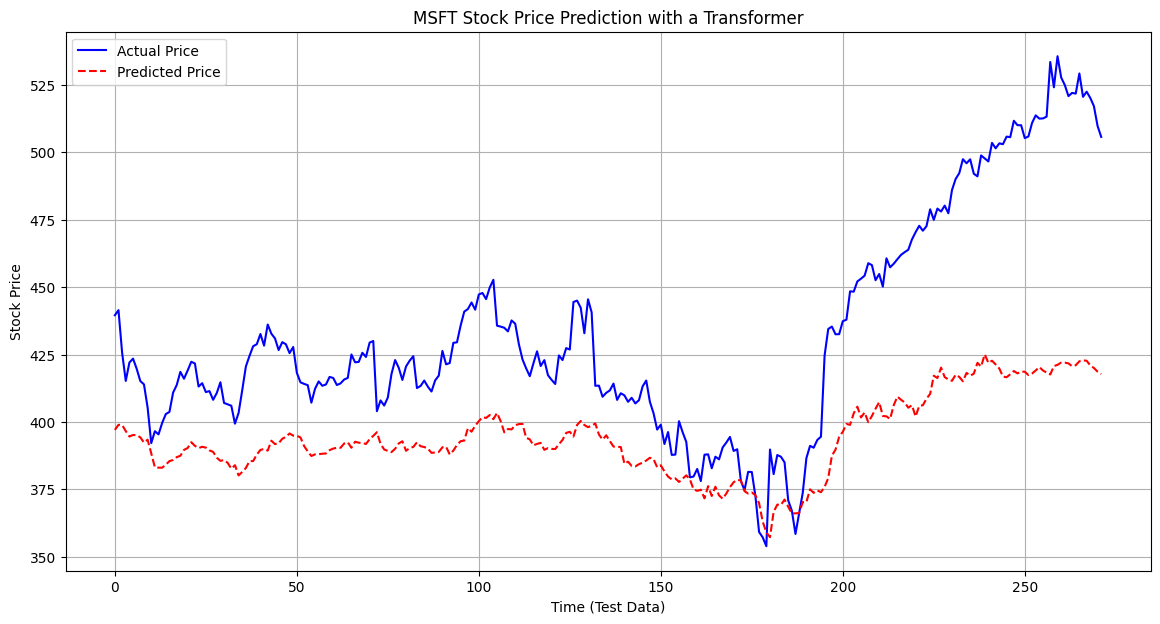

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='--')
plt.title('MSFT Stock Price Prediction with a Transformer')
plt.xlabel('Time (Test Data)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
#lookback period still used to make computationally feasible and maintain relevance